Cristobal Gomez y Pepe López 

# Proyecto de predicción de contratación de productos para clientes de un banco

## Importe de librerias

In [1856]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import average_precision_score,mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from scoring import mapk, apk
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from xgboost import XGBRegressor

## 1. Importación y Exploración Inicial de los Datos


### 1.1. Importación de los Datos

In [1857]:
# Cargar datos
dataset = pd.read_csv('dataset_para_modelar.csv')

C:\Users\crix-\AppData\Local\Temp\ipykernel_17060\3588369538.py:2: DtypeWarning: Columns (5,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('dataset_para_modelar.csv')


### 1.2. Exploración Inicial


Mostrar información básica del dataset


In [1858]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634682 entries, 0 to 634681
Data columns (total 49 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             634682 non-null  int64  
 1   cod_persona            634682 non-null  int64  
 2   mes                    634682 non-null  object 
 3   pais                   634626 non-null  object 
 4   sexo                   634617 non-null  object 
 5   edad                   634682 non-null  object 
 6   fecha1                 634626 non-null  object 
 7   xti_empleado           634626 non-null  object 
 8   xti_nuevo_cliente      634626 non-null  float64
 9   num_antiguedad         634682 non-null  object 
 10  xti_rel                634626 non-null  float64
 11  fec_ult_cli_1t         36 non-null      object 
 12  xti_rel_1mes           629040 non-null  float64
 13  tip_rel_1mes           629040 non-null  object 
 14  indresi                634626 non-nu

Descripcion de las principales metricas de cada variable

In [1859]:
dataset.describe()

,Unnamed: 0,cod_persona,xti_nuevo_cliente,xti_rel,xti_rel_1mes,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25
count,634682.000000,6.346820e+05,634626.000000,634626.000000,629040.000000,634626.0,631736.000000,634626.000000,5.105180e+05,629040.000000,634682.000000,634682.0,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634651.000000,634651.000000,634682.000000,634682.000000
mean,321920.356254,7.217769e+05,0.059846,1.005559,1.000587,1.0,26.598741,0.459126,1.367071e+05,6.425623,0.000101,0.0,0.660945,0.000495,0.081740,0.009992,0.009825,0.131909,0.043504,0.002036,0.001899,0.043438,0.083139,0.018698,0.005275,0.009263,0.002718,0.053576,0.045505,0.026503,0.003756,0.055561,0.060295,0.128827,0.065876
std,185232.719038,4.290892e+05,0.237202,0.738085,0.036560,0.0,12.777667,0.498327,3.339545e+05,1.345879,0.010041,0.0,0.473389,0.022237,0.273969,0.099461,0.098635,0.338392,0.203988,0.045072,0.043531,0.203840,0.276093,0.135455,0.072438,0.095797,0.052063,0.225180,0.208408,0.160626,0.061173,0.229073,0.238032,0.335008,0.248065
min,0.000000,5.514000e+03,0.000000,1.000000,0.000000,1.0,1.000000,0.000000,4.559550e+03,0.218520,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,161691.250000,3.584120e+05,0.000000,1.000000,1.000000,1.0,15.000000,0.000000,6.821148e+04,5.117500,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,322352.500000,6.230450e+05,0.000000,1.000000,1.000000,1.0,28.000000,0.000000,1.012905e+05,6.463518,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,482540.750000,1.102693e+06,0.000000,1.000000,1.000000,1.0,35.000000,1.000000,1.566742e+05,7.359949,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,641706.000000,1.537800e+06,1.000000,99.000000,4.000000,1.0,52.000000,1.000000,2.889440e+07,38.793123,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Primera visualizacion de las variables

In [1860]:
dataset.head(10)

,Unnamed: 0,cod_persona,mes,pais,sexo,edad,fecha1,xti_empleado,xti_nuevo_cliente,num_antiguedad,xti_rel,fec_ult_cli_1t,xti_rel_1mes,tip_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25
0,0,178103,2015-01-28,ES,H,35,2015-01-12,N,0.0,6,1.0,NaN,1.0,A,S,N,KHL,N,1.0,29.0,1.0,87218.10,02 - PARTICULARES,6.134600,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
1,1,503082,2015-01-28,ES,V,27,2012-08-10,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,40.0,0.0,70777.59,03 - UNIVERSITARIO,5.414673,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
2,2,502996,2015-01-28,ES,V,37,2012-08-10,N,0.0,35,1.0,NaN,1.0,A,S,N,KFC,N,1.0,8.0,0.0,104035.08,02 - PARTICULARES,6.301283,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
3,3,503053,2015-01-28,ES,H,23,2012-08-10,N,0.0,35,1.0,NaN,1.0,A,S,N,KHE,N,1.0,39.0,1.0,136930.23,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0
4,4,503031,2015-01-28,ES,H,44,2012-08-10,N,0.0,35,1.0,NaN,1.0,I,S,N,KAT,N,1.0,28.0,0.0,110245.53,02 - PARTICULARES,6.851770,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0
5,5,503112,2015-01-28,ES,H,23,2012-08-10,N,0.0,35,1.0,NaN,1.0,A,S,N,KHE,N,1.0,22.0,1.0,79998.72,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
6,6,503163,2015-01-28,ES,V,22,2012-08-10,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,50.0,0.0,59551.65,03 - UNIVERSITARIO,4.908936,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
7,7,503154,2015-01-28,ES,H,23,2012-08-10,N,0.0,35,1.0,NaN,1.0,A,S,N,KHE,N,1.0,15.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
8,8,503142,2015-01-28,ES,H,23,2012-08-10,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,46.0,0.0,189110.64,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
9,9,502804,2015-01-28,ES,H,24,2012-08-10,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,6.0,0.0,NaN,03 - UNIVERSITARIO,5.117500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0


## 2. Limpieza de Datos


In [1861]:
dataset.columns

Index(['Unnamed: 0', 'cod_persona', 'mes', 'pais', 'sexo', 'edad', 'fecha1',
       'xti_empleado', 'xti_nuevo_cliente', 'num_antiguedad', 'xti_rel',
       'fec_ult_cli_1t', 'xti_rel_1mes', 'tip_rel_1mes', 'indresi', 'indext',
       'des_canal', 'xti_extra', 'tip_dom', 'cod_provincia',
       'xti_actividad_cliente', 'imp_renta', 'id_segmento', 'mean_engagement',
       'ind_prod1', 'ind_prod2', 'ind_prod3', 'ind_prod4', 'ind_prod5',
       'ind_prod6', 'ind_prod7', 'ind_prod8', 'ind_prod9', 'ind_prod10',
       'ind_prod11', 'ind_prod12', 'ind_prod13', 'ind_prod14', 'ind_prod15',
       'ind_prod16', 'ind_prod17', 'ind_prod18', 'ind_prod19', 'ind_prod20',
       'ind_prod21', 'ind_prod22', 'ind_prod23', 'ind_prod24', 'ind_prod25'],
      dtype='object')

### Unnamed: 0
Index

In [1862]:
#Dropeamos el indice:
dataset.drop(columns=['Unnamed: 0'], inplace=True)

### Cod_persona
Customer	code

In [1863]:
#dataset[cod_persona]=503082 y ordenarlo por fecha1:

#Ejemplo de una persona
dataset[dataset['cod_persona']==504546].sort_values(by='fecha1') # Dataset compuesto por la evolucion de contrataciones de productos de una persona a lo largo del tiempo

,cod_persona,mes,pais,sexo,edad,fecha1,xti_empleado,xti_nuevo_cliente,num_antiguedad,xti_rel,fec_ult_cli_1t,xti_rel_1mes,tip_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25
62,504546,2015-01-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
61530,504546,2015-02-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
91495,504546,2015-03-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
123869,504546,2015-04-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
125782,504546,2015-05-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
157209,504546,2015-06-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
216829,504546,2015-07-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
254727,504546,2015-08-28,ES,H,24,2012-08-09,N,0.0,36,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.117500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
300440,504546,2015-09-28,ES,H,24,2012-08-09,N,0.0,37,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.117500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
322426,504546,2015-10-28,ES,H,24,2012-08-09,N,0.0,38,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.117500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0


In [1864]:
# Agrupar por 'cod_persona' y contar el número de registros para cada persona
conteo_registros = dataset.groupby('cod_persona').size().reset_index(name='num_registros')

# Filtrar para encontrar las personas con solo un registro
personas_con_un_registro = conteo_registros[conteo_registros['num_registros'] == 1]

# Contar el número de personas con solo un registro
num_personas_con_un_registro = personas_con_un_registro.shape[0]

print(num_personas_con_un_registro)

223


Se encuentran personas con un solo registro, lo que puede ser un problema predecir un solo registro sin un historico de contrataciones. No se eliminan los registros, ya que se considera que a pesar de tener un solo registro ese estado puede contener variables muy indicativas de compras de un producto nuevo la siguiente mensualidad.

In [1865]:
# Verificar si hay valores nulos en 'cod_persona'
print(dataset['cod_persona'].isnull().sum())

0


### mes
The	table	is	partitioned	for	this	column

In [1866]:
# Paso la columna 'mes' a datetime
dataset['mes'] = pd.to_datetime(dataset['mes'], format='%Y-%m-%d')
#Recuento de nulos:
print(dataset['mes'].isnull().sum())

0


In [1867]:
#Extraemos las caracteristicas de mes, dia y año:
dataset['mes_mes']=dataset['mes'].dt.month
dataset['mes_año']=dataset['mes'].dt.year

In [1868]:
#Se estudia el numero de registros por mes y año para ver el balanceo de clases:
print(dataset.groupby(['mes_mes', 'mes_año']).size())

mes_mes  mes_año
1        2015       30849
         2016       45994
2        2015       30988
         2016       46287
3        2015       31138
         2016       46549
4        2015       31250
         2016       46776
5        2015       31336
6        2015       31429
7        2015       41342
8        2015       42016
9        2015       43170
10       2015       44574
11       2015       45309
12       2015       45675
dtype: int64


Se observa que el dataset esta balanceado en cuanto a la cantidad de registros por mes y año.
Se observa que el historico acaba en abril de 2016 y empieza en enero de 2015. 
1 año y 4 meses de historico--> 16 meses

In [1869]:
#Como la columna mes no se puede utilizar en el modelo por estar en un formato no numerico, se decide darle un indice tomando el mes minimo y el mes maximo, al final del cuaderno se eliminará.

In [1870]:
mes_minimo = dataset['mes'].min()
dataset['mes_indice'] = dataset['mes'].apply(lambda x: (x.year - mes_minimo.year) * 12 + x.month - mes_minimo.month)

### pais
Customer's	Country	residence

In [1871]:
print(dataset['pais'].value_counts())

pais
ES    631736
DE       285
GB       244
FR       224
US       203
CH       192
CO       160
AR       144
IT       138
MX       122
RO       104
EC        90
VE        80
CL        74
PY        74
BE        64
BR        52
AT        48
CA        48
FI        32
NL        32
PL        32
CN        32
PE        32
BG        32
BO        26
GT        16
PK        16
PT        16
GN        16
PR        16
JP        16
IL        16
SA        16
NG        16
NZ        16
IN        16
AD        16
UA        16
SE        16
GE        16
CU        16
PA        16
SV        16
AU        11
MD        10
RU        10
HU         7
Name: count, dtype: int64


Se observa como la mayoría de los registros son de España, resultando el resto de paises en cifras no significativas. Se podría considerar la posibilidad de agrupar los paises con menos registros en un grupo llamado "Otros" para reducir la dimensionalidad de la variable y se mapea a 0-1. 

In [1872]:
# Crear un diccionario de mapeo para agrupar los países
#Si pais es España el valor de la columna pais_es será 1, sino 0:
dataset['pais_binario'] = dataset['pais'].apply(lambda x: 1 if x == 'ES' else 0)
dataset.drop(columns=['pais'], inplace=True)
dataset['pais_binario'].value_counts()

pais_binario
1    631736
0      2946
Name: count, dtype: int64

In [1873]:
dataset['pais_binario'].isnull().sum() #No hay valores nulos

0

### sexo
Customer's	sex

In [1874]:
dataset['sexo'].isnull().sum()

65

In [1875]:
dataset[dataset['cod_persona']==170635]

,cod_persona,mes,sexo,edad,fecha1,xti_empleado,xti_nuevo_cliente,num_antiguedad,xti_rel,fec_ult_cli_1t,xti_rel_1mes,tip_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año,mes_indice,pais_binario
51501,170635,2015-02-28,NaN,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,2,2015,1,0
82415,170635,2015-03-28,NaN,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,3,2015,2,0
113518,170635,2015-04-28,NaN,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2015,3,0
134835,170635,2015-05-28,NaN,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,5,2015,4,0
165637,170635,2015-06-28,NaN,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,6,2015,5,0
463976,170635,2016-01-28,V,40,2015-02-17,N,1.0,0,1.0,NaN,3.0,P,S,N,NaN,N,1.0,29.0,0.0,NaN,NaN,19.192186,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2016,12,1
506018,170635,2016-02-28,V,40,2015-02-17,N,1.0,1,1.0,NaN,1.0,A,S,N,KHM,N,1.0,7.0,0.0,NaN,02 - PARTICULARES,6.543075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,2,2016,13,1
550982,170635,2016-03-28,V,40,2015-02-17,N,1.0,2,1.0,NaN,1.0,I,S,N,KHM,N,1.0,7.0,0.0,NaN,02 - PARTICULARES,6.543075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,3,2016,14,1
623367,170635,2016-04-28,V,40,2015-02-17,N,1.0,3,1.0,NaN,1.0,I,S,N,KHM,N,1.0,7.0,0.0,NaN,02 - PARTICULARES,6.543075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1


Se observan que hay valores nulos en la columna 'sexo' que no en todos los registros de la misma persona son nulos. Suponiendo que el sexo de una persona no puede cambiar en el tiempo, se decide rellenar los valores nulos con el valor que tiene para otros registros.

In [1876]:
# Calcular el número de registros por 'cod_persona'
num_registros_por_persona = dataset.groupby('cod_persona').size().reset_index(name='total_registros')

# Calcular el número de valores nulos en la columna 'sexo' por cada 'cod_persona'
num_nulos_por_persona = dataset.groupby('cod_persona')['sexo'].apply(lambda x: x.isnull().sum()).reset_index(name='num_nulos')

# Unir la información de los nulos y el total de registros al dataset original
info_completa = num_registros_por_persona.merge(num_nulos_por_persona, on='cod_persona')

# Filtrar para encontrar las personas donde el número de nulos es igual al número de registros
personas_con_todos_nulos = info_completa[info_completa['total_registros'] == info_completa['num_nulos']]

print(personas_con_todos_nulos)

       cod_persona  total_registros  num_nulos
41790      1337182                9          9


La unica persona con todos los valores de sexo nulos es la persona 41790. Se decide rellenar los valores de esta persona como si fuera un hombre, son solo 9 registros por lo que no afecta a la distribución de la variable. 

In [1877]:
dataset.loc[dataset['cod_persona'] == 1337182, 'sexo'] = dataset.loc[dataset['cod_persona'] == 1337182, 'sexo'].fillna('V')

Rellenamos todos los valores nulos de cada persona con otro valor del campo sexo que ya exista para ese cod_persona

In [1878]:
valores_no_nulos = dataset.dropna(subset=['sexo']).drop_duplicates(subset=['cod_persona'], keep='first')
# Crear un diccionario con los valores no nulos
valores_no_nulos_dict = valores_no_nulos.set_index('cod_persona')['sexo'].to_dict()

#Rellenar los valores nulos en 'sexo' usando el valor no nulo correspondiente de cada 'cod_persona'
dataset['sexo'] = dataset.apply(lambda row: valores_no_nulos_dict.get(row['cod_persona'], row['sexo']) if pd.isnull(row['sexo']) else row['sexo'], axis=1)

In [1879]:
# Crear un diccionario de mapeo para asignar números a cada género
mapping_sex = {'V': 1, 'H': 0}

# Aplicar el mapeo a la columna 'customer_sex'
dataset['sexo'] = dataset['sexo'].map(mapping_sex)

In [1880]:
dataset['sexo'].value_counts()

sexo
1    346889
0    287793
Name: count, dtype: int64

### edad
Customer’s	age

In [1881]:
dataset['edad'] = pd.to_numeric(dataset['edad'], errors='coerce')

In [1882]:
dataset['edad'].isnull().sum()

56

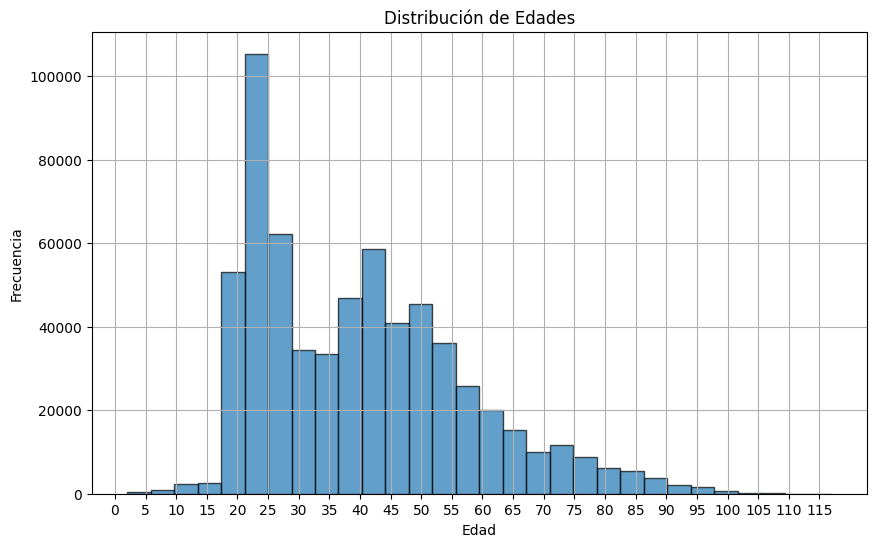

In [1883]:
# Plottear la distribución de edades
plt.figure(figsize=(10, 6))
plt.hist(dataset['edad'].dropna(), bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribución de Edades')
plt.xticks(range(0, 120, 5))
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Se observa que la distribución es bastante uniforme sin un skewness claramente definido. Sin embargo, se destaca como entre los 20-25 años hay un pico de personas.

### fecha1
The	date	in	which	the	customer	became	as	the	first	holder	of	a	contract	in	the	bank

In [1884]:
dataset['fecha1'].isnull().sum()

56

Se observa que hay 56 valores nuloes en varias columnas. Se buscan patrones e intentamos adoptar el mismo enfoque con ellas:

In [1885]:
print(dataset.isnull().sum()==56)

cod_persona              False
mes                      False
sexo                     False
edad                      True
fecha1                    True
xti_empleado              True
xti_nuevo_cliente         True
num_antiguedad           False
xti_rel                   True
fec_ult_cli_1t           False
xti_rel_1mes             False
tip_rel_1mes             False
indresi                   True
indext                    True
des_canal                False
xti_extra                 True
tip_dom                   True
cod_provincia            False
xti_actividad_cliente     True
imp_renta                False
id_segmento              False
mean_engagement          False
ind_prod1                False
ind_prod2                False
ind_prod3                False
ind_prod4                False
ind_prod5                False
ind_prod6                False
ind_prod7                False
ind_prod8                False
ind_prod9                False
ind_prod10               False
ind_prod

In [1886]:
dataset[dataset['fecha1'].isnull()]

,cod_persona,mes,sexo,edad,fecha1,xti_empleado,xti_nuevo_cliente,num_antiguedad,xti_rel,fec_ult_cli_1t,xti_rel_1mes,tip_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año,mes_indice,pais_binario
1453,532938,2015-01-28,1,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0,0,1,2015,0,0
2570,421992,2015-01-28,0,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0,0,1,2015,0,0
5323,672042,2015-01-28,0,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,0,0
7976,256163,2015-01-28,0,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,1,2015,0,0
8899,289373,2015-01-28,1,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,1,2015,0,0
9160,300713,2015-01-28,1,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,0,0
10037,210920,2015-01-28,0,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,0,0
10178,205901,2015-01-28,0,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,1,2015,0,0
10287,183684,2015-01-28,0,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,1,2015,0,0
11391,216184,2015-01-28,0,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,0,0


Todas las columnas son NaN, se dropean todos los registros

In [1887]:
#Dropeamos los registros con valores nulos dentro del subset fecha1.
dataset.dropna(subset=['fecha1'], inplace=True)

In [1888]:
dataset['fecha1'] = pd.to_datetime(dataset['fecha1'], errors='coerce')
dataset['mes'] = pd.to_datetime(dataset['mes'], errors='coerce')

In [1889]:
# Función para calcular la diferencia en meses correctamente
def calcular_meses(fecha_inicio, fecha_fin):
    return (fecha_fin.year - fecha_inicio.year) * 12 + fecha_fin.month - fecha_inicio.month


In [1890]:
dataset['meses_desde_registro'] = dataset.apply(
    lambda row: calcular_meses(row['fecha1'], row['mes']) if pd.notnull(row['fecha1']) and pd.notnull(row['mes']) else None,
    axis=1
)

In [1891]:
dataset['fecha1'] = dataset['meses_desde_registro'] #Renombramos la columna
dataset.drop(columns=['meses_desde_registro'], inplace=True) #Eliminamos la columna auxiliar

In [1892]:
dataset[dataset['cod_persona']==503082]

,cod_persona,mes,sexo,edad,fecha1,xti_empleado,xti_nuevo_cliente,num_antiguedad,xti_rel,fec_ult_cli_1t,xti_rel_1mes,tip_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año,mes_indice,pais_binario
1,503082,2015-01-28,1,27.0,29,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,40.0,0.0,70777.59,03 - UNIVERSITARIO,5.414673,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,0,1
61354,503082,2015-02-28,1,27.0,30,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,40.0,0.0,70777.59,03 - UNIVERSITARIO,5.414673,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,2,2015,1,1
91319,503082,2015-03-28,1,27.0,31,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,40.0,0.0,70777.59,03 - UNIVERSITARIO,5.414673,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,3,2015,2,1
123962,503082,2015-04-28,1,27.0,32,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,40.0,0.0,70777.59,03 - UNIVERSITARIO,5.414673,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2015,3,1
124573,503082,2015-05-28,1,27.0,33,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,40.0,0.0,70777.59,03 - UNIVERSITARIO,5.414673,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,5,2015,4,1
157144,503082,2015-06-28,1,27.0,34,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,40.0,0.0,70777.59,03 - UNIVERSITARIO,5.414673,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,6,2015,5,1
216776,503082,2015-07-28,1,27.0,35,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,40.0,0.0,70777.59,03 - UNIVERSITARIO,5.414673,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,7,2015,6,1
254793,503082,2015-08-28,1,27.0,36,N,0.0,36,1.0,NaN,1.0,I,S,N,KHE,N,1.0,40.0,0.0,70777.59,03 - UNIVERSITARIO,5.414673,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,8,2015,7,1
300518,503082,2015-09-28,1,27.0,37,N,0.0,37,1.0,NaN,1.0,I,S,N,KHE,N,1.0,40.0,0.0,70777.59,03 - UNIVERSITARIO,5.414673,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,9,2015,8,1
322461,503082,2015-10-28,1,27.0,38,N,0.0,38,1.0,NaN,1.0,I,S,N,KHE,N,1.0,40.0,0.0,70777.59,03 - UNIVERSITARIO,5.414673,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,10,2015,9,1


### xti_empleado
Employee	index:	A	active,	B	ex	employed,	F	filial,	N	not	employee

In [1893]:
dataset['xti_empleado'].isnull().sum()

0

In [1894]:
dataset['xti_empleado'].value_counts()

xti_empleado
N    634158
A       202
B       170
F        96
Name: count, dtype: int64

In [1895]:
dataset_encoded = pd.get_dummies(dataset, columns=['xti_empleado'], prefix='empleado')

In [1896]:
cols_to_convert = [col for col in dataset.columns if col.startswith('empleado_')]
dataset[cols_to_convert] = dataset[cols_to_convert].astype('Int64')

In [1897]:
if 'xti_empleado' in dataset.columns:
    dataset.drop(columns=['xti_empleado'], inplace=True)

In [1898]:
dataset.head()

,cod_persona,mes,sexo,edad,fecha1,xti_nuevo_cliente,num_antiguedad,xti_rel,fec_ult_cli_1t,xti_rel_1mes,tip_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año,mes_indice,pais_binario
0,178103,2015-01-28,0,35.0,0,0.0,6,1.0,NaN,1.0,A,S,N,KHL,N,1.0,29.0,1.0,87218.10,02 - PARTICULARES,6.134600,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,0,1
1,503082,2015-01-28,1,27.0,29,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,40.0,0.0,70777.59,03 - UNIVERSITARIO,5.414673,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,0,1
2,502996,2015-01-28,1,37.0,29,0.0,35,1.0,NaN,1.0,A,S,N,KFC,N,1.0,8.0,0.0,104035.08,02 - PARTICULARES,6.301283,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,0,1
3,503053,2015-01-28,0,23.0,29,0.0,35,1.0,NaN,1.0,A,S,N,KHE,N,1.0,39.0,1.0,136930.23,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,1,2015,0,1
4,503031,2015-01-28,0,44.0,29,0.0,35,1.0,NaN,1.0,I,S,N,KAT,N,1.0,28.0,0.0,110245.53,02 - PARTICULARES,6.851770,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,0,1


### xti_nuevo_cliente
New	customer	Index.	1	if	the	customer	registered	in	the	last	6	months

In [1899]:
# Esta variable puede obtenerse como transformación a partir de la variable 'fecha1'. Sin embargo, considera su importancia por poner un threshold de 6 meses para considerar a un cliente como "nuevo". 

In [1900]:
dataset['xti_nuevo_cliente'].value_counts()

xti_nuevo_cliente
0.0    596646
1.0     37980
Name: count, dtype: int64

Evidentemente, la clase de clientes nuevos esta desbalanceada como es lógico. 
Podríamos utilizar técnicas como SMOTE para crear una muestra sintética de la clase minoritaria, sin emargo, con el dataset tan extenso del cual disponemos no se considera necesario. Por otro lado, se podrán ajustar los pesos con los algoritmos posteriormente. 

### num_antiguedad
Customer	seniority	(in	months)

In [1901]:
#Lo casteamos a numerico :
dataset['num_antiguedad'] = pd.to_numeric(dataset['num_antiguedad'], errors='coerce')

In [1902]:
dataset['num_antiguedad'].isnull().sum()

0

In [1903]:
## Quiero que me digas el valor minimo de num_antiguedad:
dataset[dataset['num_antiguedad']==2]

,cod_persona,mes,sexo,edad,fecha1,xti_nuevo_cliente,num_antiguedad,xti_rel,fec_ult_cli_1t,xti_rel_1mes,tip_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año,mes_indice,pais_binario
126323,429432,2015-05-28,1,53.0,26,1.0,2,1.0,NaN,1.0,I,S,N,KHN,N,1.0,38.0,1.0,89227.83,02 - PARTICULARES,7.498630,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,5,2015,4,1
134720,156440,2015-05-28,0,66.0,0,1.0,2,1.0,NaN,1.0,A,S,N,KHM,N,1.0,28.0,1.0,36864.24,01 - TOP,8.342559,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,5,2015,4,1
134721,156591,2015-05-28,1,39.0,0,1.0,2,1.0,NaN,1.0,I,S,N,KHK,N,1.0,46.0,1.0,61620.72,02 - PARTICULARES,6.463518,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,5,2015,4,1
134722,156521,2015-05-28,1,30.0,0,1.0,2,1.0,NaN,1.0,A,S,N,KHK,N,1.0,18.0,0.0,126169.29,02 - PARTICULARES,5.695746,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,5,2015,4,1
134723,156499,2015-05-28,1,41.0,0,1.0,2,1.0,NaN,1.0,A,S,N,KHN,N,1.0,46.0,1.0,66977.88,02 - PARTICULARES,6.621644,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,5,2015,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628562,115195,2016-04-28,1,70.0,2,1.0,2,1.0,NaN,1.0,I,S,N,KHN,N,1.0,28.0,0.0,NaN,02 - PARTICULARES,8.585120,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1
630005,300713,2016-04-28,1,35.0,24,1.0,2,1.0,NaN,1.0,I,S,S,KHM,N,1.0,28.0,0.0,NaN,02 - PARTICULARES,6.134600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1
631449,337826,2016-04-28,1,45.0,29,1.0,2,1.0,NaN,1.0,A,S,N,KHN,N,1.0,8.0,0.0,NaN,02 - PARTICULARES,6.926724,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1
631723,334766,2016-04-28,0,45.0,2,1.0,2,1.0,NaN,1.0,I,S,N,KHM,N,1.0,8.0,0.0,NaN,02 - PARTICULARES,6.926724,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1


In [1904]:
dataset[dataset['cod_persona']==503031] ## Para todos los clientes el num_antiguedad se incrementa de forma sincronizada con la fecha1. No se elimina la columna porque en determinadas circunstancias cambia el patrón.

,cod_persona,mes,sexo,edad,fecha1,xti_nuevo_cliente,num_antiguedad,xti_rel,fec_ult_cli_1t,xti_rel_1mes,tip_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año,mes_indice,pais_binario
4,503031,2015-01-28,0,44.0,29,0.0,35,1.0,NaN,1.0,I,S,N,KAT,N,1.0,28.0,0.0,110245.53,02 - PARTICULARES,6.851770,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,0,1
61345,503031,2015-02-28,0,44.0,30,0.0,35,1.0,NaN,1.0,I,S,N,KAT,N,1.0,28.0,0.0,110245.53,02 - PARTICULARES,6.851770,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,2,2015,1,1
91328,503031,2015-03-28,0,44.0,31,0.0,35,1.0,NaN,1.0,I,S,N,KAT,N,1.0,28.0,0.0,110245.53,02 - PARTICULARES,6.851770,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,3,2015,2,1
123960,503031,2015-04-28,0,44.0,32,0.0,35,1.0,NaN,1.0,I,S,N,KAT,N,1.0,28.0,0.0,110245.53,02 - PARTICULARES,6.851770,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2015,3,1
124570,503031,2015-05-28,0,44.0,33,0.0,35,1.0,NaN,1.0,I,S,N,KAT,N,1.0,28.0,0.0,110245.53,02 - PARTICULARES,6.851770,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,5,2015,4,1
157143,503031,2015-06-28,0,44.0,34,0.0,35,1.0,NaN,1.0,I,S,N,KAT,N,1.0,28.0,0.0,110245.53,02 - PARTICULARES,6.851770,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,6,2015,5,1
216787,503031,2015-07-28,0,44.0,35,0.0,35,1.0,NaN,1.0,I,S,N,KAT,N,1.0,28.0,0.0,110245.53,02 - PARTICULARES,6.851770,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,7,2015,6,1
254792,503031,2015-08-28,0,44.0,36,0.0,36,1.0,NaN,1.0,I,S,N,KAT,N,1.0,28.0,0.0,110245.53,02 - PARTICULARES,6.851770,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,8,2015,7,1
300526,503031,2015-09-28,0,44.0,37,0.0,37,1.0,NaN,1.0,I,S,N,KAT,N,1.0,28.0,0.0,110245.53,02 - PARTICULARES,6.851770,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,9,2015,8,1
322460,503031,2015-10-28,0,45.0,38,0.0,38,1.0,NaN,1.0,I,S,N,KAT,N,1.0,28.0,0.0,110245.53,02 - PARTICULARES,6.926724,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,10,2015,9,1


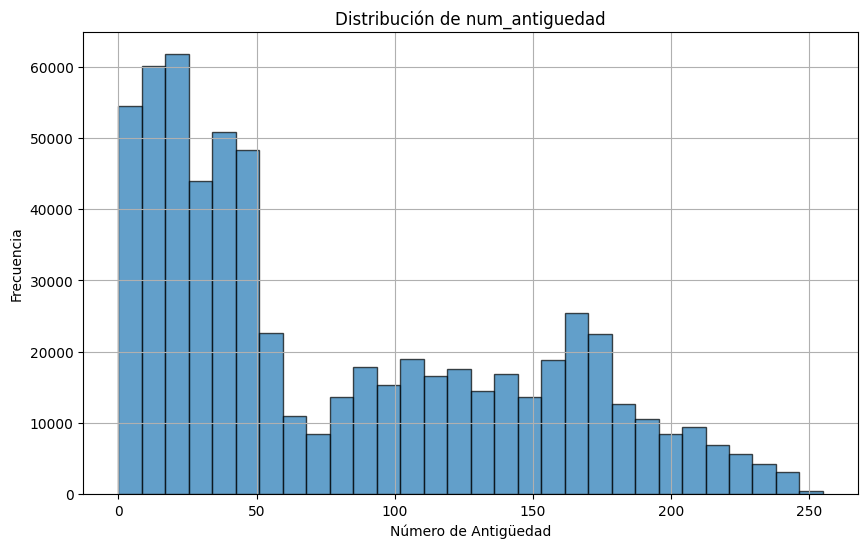

In [1905]:
plt.figure(figsize=(10, 6))
plt.hist(dataset['num_antiguedad'].dropna(), bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribución de num_antiguedad')
plt.xlabel('Número de Antigüedad')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Todos los datos quedan comprendidos en un intervalo de mses de antiguedad de 0 a 250. Se observa cierto sesgo en la distribucion hacia la izquierda, reflejando un patron de contratación muy alto hasta el mes 50. Posteriormente, se produce una reduccion significativa de los clientes abandonando el banco, y el número de fieles queda en una cola constante.

### xti_rel
1(First/Primary),	99	(Primary	customer	during	the	month	but	not	at	the	end	of	the	month)

In [1906]:
dataset['xti_rel']=pd.to_numeric(dataset['xti_rel'], errors='coerce')

In [1907]:
dataset['xti_rel'].isnull().sum()

0

In [1908]:
xti_rel_counts = dataset['xti_rel'].value_counts()
xti_rel_counts

xti_rel
1.0     634590
99.0        36
Name: count, dtype: int64

In [1909]:
 #mapea esto 99.0 a 0 1.0 a 1:
dataset['xti_rel'] = dataset['xti_rel'].apply(lambda x: 1 if x == 1 else 0)

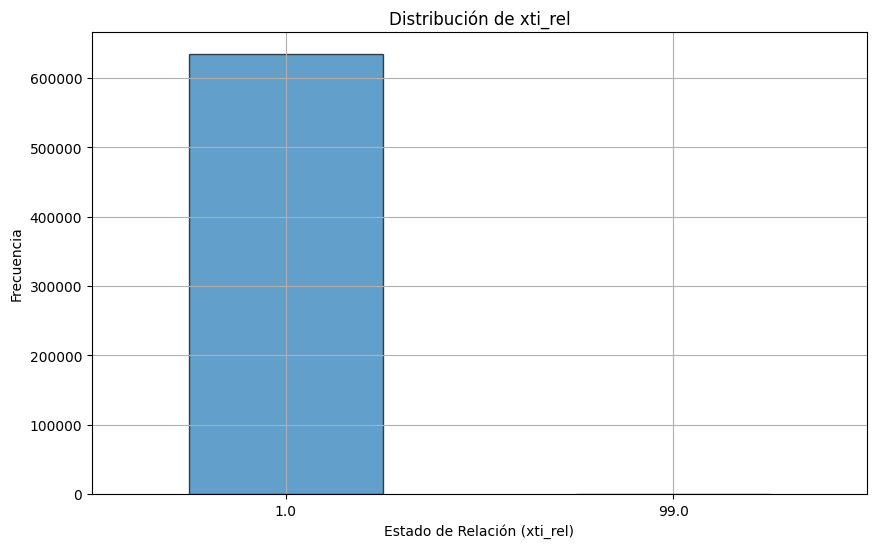

In [1910]:
# Graficar la distribución de 'xti_rel'
plt.figure(figsize=(10, 6))
xti_rel_counts.plot(kind='bar', edgecolor='k', alpha=0.7)
plt.title('Distribución de xti_rel')
plt.xlabel('Estado de Relación (xti_rel)')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

### fec_ult_cli_1t
Last	date	as	primary	customer	(if	he	isn't	at	the	end	of	the	month)

In [1911]:
dataset['fec_ult_cli_1t'].value_counts().sum() #Son los mismos 36 calculados previamente

36

In [1912]:
dataset['fec_ult_cli_1t'].isnull().sum() #Todos estos nulos 

634590

Vamos a utilizar la diferencia de dias entre "mes" y "fec_ult_cli_1t" para ver la diferencia entre la fecha y la fecha ultima en la que el cliente fue el cliente principal para determinar la relacion ent

In [1913]:
#No muestres lo que son null:
dataset[dataset['fec_ult_cli_1t'].notnull()]
dataset.loc[dataset['fec_ult_cli_1t'].notnull(), ['mes', 'fec_ult_cli_1t','cod_persona']].sort_values(by=['cod_persona','mes'], ascending=[True,True])

,mes,fec_ult_cli_1t,cod_persona
594903,2016-04-28,2016-04-01,12917
504235,2016-02-28,2016-02-04,25275
460208,2016-01-28,2016-01-12,31771
373778,2015-11-28,2015-11-24,49462
372695,2015-11-28,2015-11-02,58115
372692,2015-11-28,2015-11-02,58121
327830,2015-10-28,2015-10-02,87527
443075,2015-12-28,2015-12-17,98525
309465,2015-09-28,2015-09-15,141487
448835,2015-12-28,2015-12-24,147235


In [1914]:
dataset[dataset['cod_persona']==319866].sort_values(by='mes')

,cod_persona,mes,sexo,edad,fecha1,xti_nuevo_cliente,num_antiguedad,xti_rel,fec_ult_cli_1t,xti_rel_1mes,tip_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año,mes_indice,pais_binario
14404,319866,2015-01-28,1,23.0,13,0.0,19,1,NaN,1.0,I,S,N,KHE,N,1.0,18.0,0.0,110344.65,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,0,1
48111,319866,2015-02-28,1,23.0,14,0.0,19,1,NaN,1.0,I,S,N,KHE,N,1.0,18.0,0.0,110344.65,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,2,2015,1,1
78989,319866,2015-03-28,1,23.0,15,0.0,19,1,NaN,1.0,I,S,N,KHE,N,1.0,18.0,0.0,110344.65,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,3,2015,2,1
110156,319866,2015-04-28,1,23.0,16,0.0,19,1,NaN,1.0,I,S,N,KHE,N,1.0,18.0,0.0,110344.65,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2015,3,1
138275,319866,2015-05-28,1,23.0,17,0.0,19,1,NaN,1.0,I,S,N,KHE,N,1.0,18.0,0.0,110344.65,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,5,2015,4,1
169661,319866,2015-06-28,1,23.0,18,0.0,19,1,NaN,1.0,I,S,N,KHE,N,1.0,18.0,0.0,110344.65,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,6,2015,5,1
224883,319866,2015-07-28,1,23.0,19,0.0,19,1,NaN,1.0,I,S,N,KHE,N,1.0,18.0,0.0,110344.65,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,7,2015,6,1
257978,319866,2015-08-28,1,23.0,20,0.0,20,1,NaN,1.0,I,S,N,KHE,N,1.0,18.0,0.0,110344.65,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,8,2015,7,1
293704,319866,2015-09-28,1,23.0,21,0.0,21,0,2015-09-24,1.0,I,S,N,KHE,N,1.0,18.0,0.0,110344.65,03 - UNIVERSITARIO,5.014352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,9,2015,8,1
629227,319866,2016-04-28,1,24.0,28,1.0,0,1,NaN,3.0,P,S,N,NaN,N,1.0,18.0,0.0,110344.65,NaN,14.915459,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1


Se observa que el patron comun de aparición de una fecha en 'fec_ult_cli_1t' el cliente viene de estar inactivo durante una serie de meses, al mes siguiente se convierte en principal un mes y vuelve a estar inactivo.

Se comprueba que tiene que una especial correlacion con xti_rel_1mes resultando siempre el siguiente registro en 3 y con tip_1_1mes resultado el siguiente registro en "P", y con xti_rel resultando en 0. Teniendo en cuenta que otras columnas ya absorben esta información, se decide prescindir de esta columna.

In [1915]:
dataset.drop(columns=['fec_ult_cli_1t'], inplace=True)

### tip_rel_1mes
Customer	 relation	 type	at	 the	 beginning	 of	 the	month,	A	 (active),	 I	 (inactive),	P	 (former	 customer),R	
(Potential)

Ocurre exactamente lo mismo con tip_rel_1mes que con fec_ult_cli_1t, se decide aplicar el mismo metodo de rellenado.

In [1916]:
dataset['tip_rel_1mes'].value_counts()

tip_rel_1mes
I    340711
A    288119
P       171
R        39
Name: count, dtype: int64

In [1917]:
# Ordenar el DataFrame por 'cod_persona' y 'mes'
dataset = dataset.sort_values(by=['cod_persona', 'mes'])

# Rellenar valores nulos en 'tip_rel_1mes' con el siguiente valor en la secuencia temporal
dataset['tip_rel_1mes'] = dataset.groupby('cod_persona')['tip_rel_1mes'].fillna(method='bfill')

# Si aún quedan valores nulos, rellenar con un valor predeterminado, por ejemplo, 'A' para activo
dataset['tip_rel_1mes'] = dataset['tip_rel_1mes'].fillna('A')


C:\Users\crix-\AppData\Local\Temp\ipykernel_17060\3516323669.py:5: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  dataset['tip_rel_1mes'] = dataset.groupby('cod_persona')['tip_rel_1mes'].fillna(method='bfill')
C:\Users\crix-\AppData\Local\Temp\ipykernel_17060\3516323669.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset['tip_rel_1mes'] = dataset.groupby('cod_persona')['tip_rel_1mes'].fillna(method='bfill')
C:\Users\crix-\AppData\Local\Temp\ipykernel_17060\3516323669.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_sile

In [1918]:
dataset = pd.get_dummies(dataset, columns=['tip_rel_1mes'], prefix='tip_rel_1mes')


In [1919]:
dataset.head(10)

,cod_persona,mes,sexo,edad,fecha1,xti_nuevo_cliente,num_antiguedad,xti_rel,xti_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año,mes_indice,pais_binario,tip_rel_1mes_A,tip_rel_1mes_I,tip_rel_1mes_P,tip_rel_1mes_R
595039,5514,2016-04-28,0,44.0,0,1.0,0,1,NaN,S,N,NaN,N,1.0,8.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False
595040,5541,2016-04-28,0,60.0,0,1.0,0,1,NaN,S,N,NaN,N,1.0,41.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False
595045,5631,2016-04-28,1,53.0,0,1.0,0,1,NaN,S,N,NaN,N,1.0,15.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False
595046,5656,2016-04-28,0,47.0,0,1.0,0,1,NaN,S,N,NaN,N,1.0,46.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False
594981,5738,2016-04-28,1,48.0,0,1.0,0,1,NaN,S,N,NaN,N,1.0,28.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False
594988,5841,2016-04-28,0,22.0,0,1.0,0,1,NaN,S,N,NaN,N,1.0,28.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False
594987,5863,2016-04-28,0,25.0,0,1.0,0,1,NaN,S,N,NaN,N,1.0,28.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False
594989,5880,2016-04-28,1,53.0,0,1.0,0,1,NaN,S,N,NaN,N,1.0,29.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False
594986,5902,2016-04-28,0,36.0,0,1.0,0,1,NaN,S,S,NaN,N,1.0,12.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False
594984,5926,2016-04-28,0,21.0,0,1.0,0,1,NaN,S,N,NaN,N,1.0,9.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False


### xti_rel_1mes
Customer	type	at	the	beginning	of	the	month	,1	(First/Primary	customer),	2	(co-owner	),P	(Potential),3	
(former	primary),	4(former	co-owner)

In [1920]:
dataset['xti_rel_1mes'].isnull().sum() #Todos estos nulos 

5586

In [1921]:
dataset['xti_rel_1mes'].value_counts()

xti_rel_1mes
1.0    628777
3.0       158
2.0        53
0.0        39
4.0        13
Name: count, dtype: int64

In [1922]:
#Se comprueba que esta pasando con los registros nulos:
dataset[dataset['xti_rel_1mes'].isnull()].head(6)

,cod_persona,mes,sexo,edad,fecha1,xti_nuevo_cliente,num_antiguedad,xti_rel,xti_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año,mes_indice,pais_binario,tip_rel_1mes_A,tip_rel_1mes_I,tip_rel_1mes_P,tip_rel_1mes_R
595039,5514,2016-04-28,0,44.0,0,1.0,0,1,NaN,S,N,NaN,N,1.0,8.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False
595040,5541,2016-04-28,0,60.0,0,1.0,0,1,NaN,S,N,NaN,N,1.0,41.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False
595045,5631,2016-04-28,1,53.0,0,1.0,0,1,NaN,S,N,NaN,N,1.0,15.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False
595046,5656,2016-04-28,0,47.0,0,1.0,0,1,NaN,S,N,NaN,N,1.0,46.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False
594981,5738,2016-04-28,1,48.0,0,1.0,0,1,NaN,S,N,NaN,N,1.0,28.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False
594988,5841,2016-04-28,0,22.0,0,1.0,0,1,NaN,S,N,NaN,N,1.0,28.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False


In [1923]:
# dataset[dataset['cod_persona']==714704].sort_values(by='mes')
# dataset[dataset['cod_persona']==172131].sort_values(by='mes')
dataset[dataset['cod_persona']==136612].sort_values(by='mes')


,cod_persona,mes,sexo,edad,fecha1,xti_nuevo_cliente,num_antiguedad,xti_rel,xti_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año,mes_indice,pais_binario,tip_rel_1mes_A,tip_rel_1mes_I,tip_rel_1mes_P,tip_rel_1mes_R
227242,136612,2015-07-28,1,19.0,0,1.0,0,1,NaN,S,N,NaN,N,1.0,34.0,0.0,86593.08,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,7,2015,6,1,True,False,False,False
250201,136612,2015-08-28,1,19.0,1,1.0,1,1,1.0,S,N,KHQ,N,1.0,34.0,1.0,86593.08,02 - PARTICULARES,4.577419,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,8,2015,7,1,True,False,False,False
312243,136612,2015-09-28,1,19.0,2,1.0,2,1,1.0,S,N,KHQ,N,1.0,34.0,1.0,86593.08,02 - PARTICULARES,4.577419,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,9,2015,8,1,False,True,False,False
325788,136612,2015-10-28,1,20.0,3,1.0,3,1,1.0,S,N,KHQ,N,1.0,34.0,1.0,86593.08,02 - PARTICULARES,4.690656,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,10,2015,9,1,True,False,False,False
358169,136612,2015-11-28,1,20.0,4,1.0,4,1,1.0,S,N,KHQ,N,1.0,34.0,1.0,86593.08,03 - UNIVERSITARIO,4.690656,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,11,2015,10,1,True,False,False,False
447217,136612,2015-12-28,1,20.0,5,1.0,5,1,1.0,S,N,KHQ,N,1.0,34.0,1.0,86593.08,03 - UNIVERSITARIO,4.690656,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,12,2015,11,1,True,False,False,False
449872,136612,2016-01-28,1,20.0,6,0.0,6,1,1.0,S,N,KHQ,N,1.0,34.0,1.0,86593.08,03 - UNIVERSITARIO,4.690656,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2016,12,1,True,False,False,False
505598,136612,2016-02-28,1,20.0,7,0.0,7,1,1.0,S,N,KHQ,N,1.0,34.0,1.0,86593.08,03 - UNIVERSITARIO,4.690656,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,2,2016,13,1,True,False,False,False
544171,136612,2016-03-28,1,20.0,8,0.0,8,1,1.0,S,N,KHQ,N,1.0,34.0,1.0,86593.08,03 - UNIVERSITARIO,4.690656,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,3,2016,14,1,True,False,False,False
623892,136612,2016-04-28,1,20.0,9,0.0,9,1,1.0,S,N,KHQ,N,1.0,34.0,1.0,86593.08,03 - UNIVERSITARIO,4.690656,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False


Se observa que el primer valor a cada cod_persona de xti_rel1_mes es el nulo, esto es obvio ya que esta columna es una transformación de la resta de otra. Se opta por poner directamente como el siguiente valor 

In [1924]:
dataset = dataset.sort_values(by=['cod_persona', 'mes'])
dataset['xti_rel_1mes'] = dataset.groupby('cod_persona')['xti_rel_1mes'].fillna(method='bfill')

C:\Users\crix-\AppData\Local\Temp\ipykernel_17060\1891280317.py:2: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  dataset['xti_rel_1mes'] = dataset.groupby('cod_persona')['xti_rel_1mes'].fillna(method='bfill')
C:\Users\crix-\AppData\Local\Temp\ipykernel_17060\1891280317.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset['xti_rel_1mes'] = dataset.groupby('cod_persona')['xti_rel_1mes'].fillna(method='bfill')


In [1925]:
# Si aún quedan valores nulos (por ejemplo, si no hay un siguiente valor disponible), rellenar con un valor predeterminado, por ejemplo, 1 (que es el mas comun)
dataset['xti_rel_1mes'] = dataset['xti_rel_1mes'].fillna(1)

### Indresi

Residence	index	(S	(Yes)	or	N	(No)	if	the	residence	country	is	the	same	than	the	bank	country)


In [1926]:
print(dataset['indresi'].dtype)

object


In [1927]:
dataset['indresi'].value_counts()
dataset['indresi'] = dataset['indresi'].map({'S': 1, 'N': 0})

In [1928]:
dataset['indresi'].value_counts()


indresi
1    631736
0      2890
Name: count, dtype: int64

In [1929]:
#to Int64
dataset['indresi'] = dataset['indresi'].astype('Int64')
dataset['indresi'].value_counts()

indresi
1    631736
0      2890
Name: count, dtype: Int64

### indext

Foreigner	index	(S	(Yes)	or	N	(No)	if	the	customer's	birth	country	is	different	than	the	bank	country)


In [1930]:
dataset['indext'].value_counts()

indext
N    604219
S     30407
Name: count, dtype: int64

In [1931]:
dataset['indext'].value_counts()
dataset['indext'] = dataset['indext'].map({'S': 1, 'N': 0})

In [1932]:
#to Int64
dataset['indresi'] = dataset['indresi'].astype('Int64')
dataset['indresi'].value_counts()

indresi
1    631736
0      2890
Name: count, dtype: Int64

### des_canal

Channel	used	by	the	customer	to	join    the	bank

In [1933]:
print(dataset['des_canal'].dtype)

object


In [1934]:
# Convertir la columna 'edad' a tipo int
dataset['edad'] = dataset['edad'].astype(int)

In [1935]:

# Crear categorías de edad
thresholds = [0, 20, 35, 50, 65, 80, 95, 110]
age_labels = ['0-19', '20-34', '35-49', '50-64', '65-79', '80-94', '95-109']
dataset['edad_grupo'] = pd.cut(dataset['edad'], bins=thresholds, labels=age_labels, right=False)

In [1936]:
# Función para obtener la moda o NaN
def obtener_moda_o_nan(serie):
    modas = serie.mode()
    return modas.iloc[0] if not modas.empty else np.nan

# Calcular la moda de 'des_canal' para cada categoría de edad
moda_por_edad = dataset.groupby('edad_grupo', observed=True)['des_canal'].apply(obtener_moda_o_nan).reset_index()
moda_por_edad.columns = ['edad_grupo', 'moda_des_canal']

In [1937]:

# Unir las modas al DataFrame original
dataset = dataset.merge(moda_por_edad, on='edad_grupo', how='left')

# Imputar valores nulos en 'des_canal' con la moda correspondiente
dataset['des_canal'] = dataset.apply(
    lambda row: row['moda_des_canal'] if pd.isnull(row['des_canal']) else row['des_canal'],
    axis=1
)

In [1938]:

# Eliminar columna temporal
dataset.drop(columns=['moda_des_canal', 'edad_grupo'], inplace=True)

In [1939]:
# count nulls
dataset['des_canal'].isnull().sum()

0

In [1940]:
dataset.isnull().sum()

cod_persona                   0
mes                           0
sexo                          0
edad                          0
fecha1                        0
xti_nuevo_cliente             0
num_antiguedad                0
xti_rel                       0
xti_rel_1mes                  0
indresi                       0
indext                        0
des_canal                     0
xti_extra                     0
tip_dom                       0
cod_provincia              2890
xti_actividad_cliente         0
imp_renta                124108
id_segmento                7347
mean_engagement            5586
ind_prod1                     0
ind_prod2                     0
ind_prod3                     0
ind_prod4                     0
ind_prod5                     0
ind_prod6                     0
ind_prod7                     0
ind_prod8                     0
ind_prod9                     0
ind_prod10                    0
ind_prod11                    0
ind_prod12                    0
ind_prod

In [1941]:
dataset['des_canal'].value_counts()

des_canal
KHE    195663
KAT    153151
KFC    148235
KHQ     25773
KFA     18941
        ...  
KCP        10
KDV        10
KFM        10
K00        10
KCO        10
Name: count, Length: 126, dtype: int64

In [1942]:
frequency = dataset['des_canal'].value_counts()

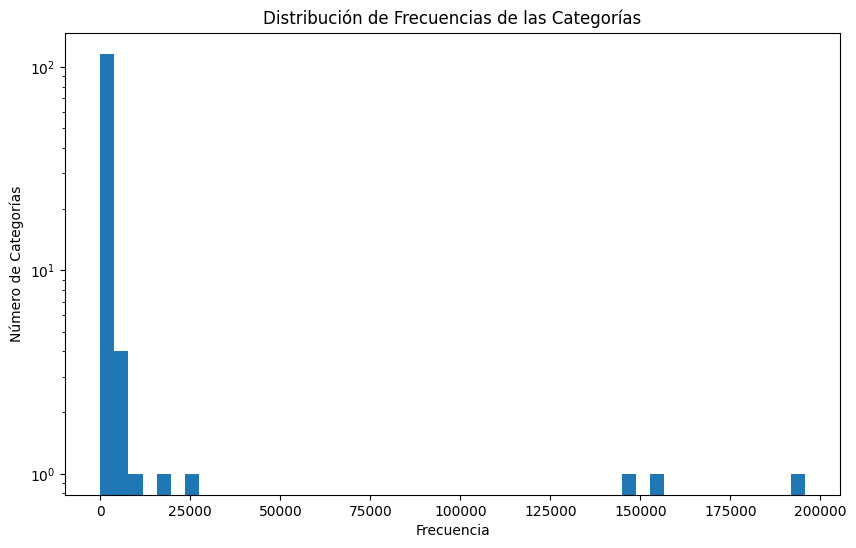

In [1943]:
# Calcular la distribución de frecuencias
plt.figure(figsize=(10, 6))
plt.hist(frequency, bins=50, log=True)
plt.xlabel('Frecuencia')
plt.ylabel('Número de Categorías')
plt.title('Distribución de Frecuencias de las Categorías')
plt.show()

In [1944]:
# Definir un umbral basado en el percentil 90 (puedes ajustar este percentil)
threshold = np.percentile(frequency, 90)
print(f"Umbral basado en el percentil 90: {threshold}")

Umbral basado en el percentil 90: 2980.0


In [1945]:
dataset['des_canal_grouped'] = dataset['des_canal']
dataset.loc[dataset['des_canal'].isin(frequency[frequency < threshold].index), 'des_canal_grouped'] = 'otros'

In [1946]:
print(dataset['des_canal_grouped'].value_counts())


des_canal_grouped
KHE      195663
KAT      153151
KFC      148235
otros     50222
KHQ       25773
KFA       18941
KHK       11218
KHM        7310
KHD        5456
KHN        4699
KAS        4072
KAG        3574
RED        3328
KAB        2984
Name: count, dtype: int64


In [1947]:
dataset = pd.get_dummies(dataset, columns=['des_canal_grouped'])
dataset.drop(columns=['des_canal'], inplace=True)

In [1948]:
dataset.head()


,cod_persona,mes,sexo,edad,fecha1,xti_nuevo_cliente,num_antiguedad,xti_rel,xti_rel_1mes,indresi,indext,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año,mes_indice,pais_binario,tip_rel_1mes_A,tip_rel_1mes_I,tip_rel_1mes_P,tip_rel_1mes_R,des_canal_grouped_KAB,des_canal_grouped_KAG,des_canal_grouped_KAS,des_canal_grouped_KAT,des_canal_grouped_KFA,des_canal_grouped_KFC,des_canal_grouped_KHD,des_canal_grouped_KHE,des_canal_grouped_KHK,des_canal_grouped_KHM,des_canal_grouped_KHN,des_canal_grouped_KHQ,des_canal_grouped_RED,des_canal_grouped_otros
0,5514,2016-04-28,0,44,0,1.0,0,1,1.0,1,0,N,1.0,8.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1,5541,2016-04-28,0,60,0,1.0,0,1,1.0,1,0,N,1.0,41.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,5631,2016-04-28,1,53,0,1.0,0,1,1.0,1,0,N,1.0,15.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,5656,2016-04-28,0,47,0,1.0,0,1,1.0,1,0,N,1.0,46.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,5738,2016-04-28,1,48,0,1.0,0,1,1.0,1,0,N,1.0,28.0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


### xti_extra

Deceased	index.	N/S


In [1949]:
dataset['xti_extra'].value_counts()

xti_extra
N    633108
S      1518
Name: count, dtype: int64

In [1950]:
dataset['xti_extra'] = dataset['xti_extra'].map({'S': 1, 'N': 0})
dataset['xti_extra']  = dataset['xti_extra'].astype('Int64')

In [1951]:
dataset['xti_extra'].value_counts()

xti_extra
0    633108
1      1518
Name: count, dtype: Int64

In [1952]:
# dime si hay algun cod_persona que tenga xti_extra = 1 y xti_extra = 0
dataset.groupby('cod_persona')['xti_extra'].nunique().value_counts()

xti_extra
1    46763
2       16
Name: count, dtype: int64

In [1953]:
# Si hay algun cod_persona que tenga xti_extra = 1 y xti_extra = 0 vamos a sacar los valores cod_persona
cod_personas_con_xti_extra_ambos = dataset.groupby('cod_persona')['xti_extra'].nunique()
cod_personas_con_xti_extra_ambos = cod_personas_con_xti_extra_ambos[cod_personas_con_xti_extra_ambos == 2].index

In [1954]:
cod_personas_con_xti_extra_ambos

Index([ 315613,  478242,  667532,  750560, 1158120, 1241973, 1292676, 1366657,
       1438552, 1448906, 1453113, 1457279, 1506511, 1511385, 1513673, 1527641],
      dtype='int64', name='cod_persona')

In [1955]:
# Vamos a ver los registros de estos cod_persona
dataset[dataset['cod_persona'].isin(cod_personas_con_xti_extra_ambos)]

,cod_persona,mes,sexo,edad,fecha1,xti_nuevo_cliente,num_antiguedad,xti_rel,xti_rel_1mes,indresi,indext,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año,mes_indice,pais_binario,tip_rel_1mes_A,tip_rel_1mes_I,tip_rel_1mes_P,tip_rel_1mes_R,des_canal_grouped_KAB,des_canal_grouped_KAG,des_canal_grouped_KAS,des_canal_grouped_KAT,des_canal_grouped_KFA,des_canal_grouped_KFC,des_canal_grouped_KHD,des_canal_grouped_KHE,des_canal_grouped_KHK,des_canal_grouped_KHM,des_canal_grouped_KHN,des_canal_grouped_KHQ,des_canal_grouped_RED,des_canal_grouped_otros
132222,315613,2015-01-28,1,52,12,0.0,18,1,1.0,1,0,0,1.0,8.0,1.0,85950.03,02 - PARTICULARES,7.429623,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,1,2015,0,1,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
132223,315613,2015-02-28,1,52,13,0.0,18,1,1.0,1,0,0,1.0,8.0,1.0,85950.03,02 - PARTICULARES,7.429623,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,2,2015,1,1,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
132224,315613,2015-03-28,1,52,14,0.0,18,1,1.0,1,0,0,1.0,8.0,1.0,85950.03,02 - PARTICULARES,7.429623,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,3,2015,2,1,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
132225,315613,2015-04-28,1,52,15,0.0,18,1,1.0,1,0,0,1.0,8.0,1.0,85950.03,02 - PARTICULARES,7.429623,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,4,2015,3,1,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
132226,315613,2015-05-28,1,52,16,0.0,18,1,1.0,1,0,0,1.0,8.0,1.0,85950.03,02 - PARTICULARES,7.429623,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,5,2015,4,1,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631010,1527641,2015-12-28,1,73,229,0.0,215,1,1.0,1,0,1,1.0,28.0,1.0,148376.82,02 - PARTICULARES,8.762524,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,12,2015,11,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
631011,1527641,2016-01-28,1,73,230,0.0,216,1,1.0,1,0,1,1.0,28.0,1.0,148376.82,02 - PARTICULARES,8.762524,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2016,12,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
631012,1527641,2016-02-28,1,73,231,0.0,217,1,1.0,1,0,1,1.0,28.0,1.0,148376.82,02 - PARTICULARES,8.762524,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,2,2016,13,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
631013,1527641,2016-03-28,1,73,232,0.0,218,1,1.0,1,0,1,1.0,28.0,1.0,148376.82,02 - PARTICULARES,8.762524,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,3,2016,14,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [1956]:
# Vamos a ver si hay algun cod_persona que tenga xti_extra = 1 y xti_extra = 0 en el mismo mes
dataset.groupby(['cod_persona', 'mes'])['xti_extra'].nunique().value_counts()

xti_extra
1    634626
Name: count, dtype: int64

Se observa que no hay personas que tienen valores diferentes de xti_extra para el mismo mes. Pero si hay personas que tienen valores diferentes de xti_extra para diferentes meses. Se decide mantener los valores de xti_extra tal y como están ya que no hay ninguna inconsistencia en los datos y además  con estos cambios entre "la vida y la muerte" se pueden obtener patrones de contratación de productos.

### tip_dom

Addres	type.	1,	primary	address


In [1957]:
dataset['tip_dom'].isnull().sum()

0

In [1958]:
dataset['tip_dom'].value_counts()

tip_dom
1.0    634626
Name: count, dtype: int64

Se observa que todos los registros son de tipo 1. Se decide eliminar la columna ya que no aporta información.

In [1959]:
dataset.drop(columns=['tip_dom'], inplace=True)

### cod_provincia

Province	code	(customer's	address)


In [1960]:
dataset['cod_provincia'].isnull().sum()

2890

In [1961]:
# Ver la distribución de la variable 'cod_provincia' por pais en los nulls
dataset[dataset['cod_provincia'].isnull()]['pais_binario'].value_counts()

pais_binario
0    2890
Name: count, dtype: int64

Se observa que todos los valores nulos de 'cod_provincia' son de personas que no son de España. Se decide aplicar un 99 a los valores nulos para que no se pierda la información de la provincia.

In [1962]:
dataset['cod_provincia'] = dataset['cod_provincia'].fillna(99)

In [1963]:
# Crear un diccionario de mapeo de códigos de provincia a nombres de provincia
mapeo_provincias = {
    1: 'Álava',
    2: 'Albacete',
    3: 'Alicante',
    4: 'Almería',
    5: 'Ávila',
    6: 'Badajoz',
    7: 'Islas Baleares',
    8: 'Barcelona',
    9: 'Burgos',
    10: 'Cáceres',
    11: 'Cádiz',
    12: 'Castellón',
    13: 'Ciudad Real',
    14: 'Córdoba',
    15: 'A Coruña',
    16: 'Cuenca',
    17: 'Girona',
    18: 'Granada',
    19: 'Guadalajara',
    20: 'Gipuzkoa',
    21: 'Huelva',
    22: 'Huesca',
    23: 'Jaén',
    24: 'León',
    25: 'Lleida',
    26: 'La Rioja',
    27: 'Lugo',
    28: 'Madrid',
    29: 'Málaga',
    30: 'Murcia',
    31: 'Navarra',
    32: 'Ourense',
    33: 'Asturias',
    34: 'Palencia',
    35: 'Las Palmas',
    36: 'Pontevedra',
    37: 'Salamanca',
    38: 'Santa Cruz de Tenerife',
    39: 'Cantabria',
    40: 'Segovia',
    41: 'Sevilla',
    42: 'Soria',
    43: 'Tarragona',
    44: 'Teruel',
    45: 'Toledo',
    46: 'Valencia',
    47: 'Valladolid',
    48: 'Bizkaia',
    49: 'Zamora',
    50: 'Zaragoza',
    51: 'Ceuta',
    52: 'Melilla',
    99: 'Desconocido'  # Incluyo un código para los casos desconocidos
}

# Mapear los códigos de provincia a nombres de provincia
dataset['cod_provincia'] = dataset['cod_provincia'].map(mapeo_provincias)

In [1964]:
frequency_prov = dataset['cod_provincia'].value_counts()

In [1965]:
# Calcular la distribución de frecuencias
dataset['cod_provincia'].value_counts()

cod_provincia
Madrid                    206951
Barcelona                  60268
Valencia                   32160
Sevilla                    28197
A Coruña                   19160
Murcia                     18386
Málaga                     16899
Zaragoza                   16403
Alicante                   14211
Cádiz                      12844
Pontevedra                 12819
Asturias                   12471
Valladolid                 10936
Las Palmas                 10688
Badajoz                     9079
Granada                     8724
Toledo                      8677
Bizkaia                     8529
Salamanca                   7520
Cantabria                   7390
Córdoba                     6895
Huelva                      6217
Cáceres                     6099
Islas Baleares              5670
Ciudad Real                 5424
Albacete                    5182
Castellón                   5159
Tarragona                   4681
León                        4323
Burgos                      4

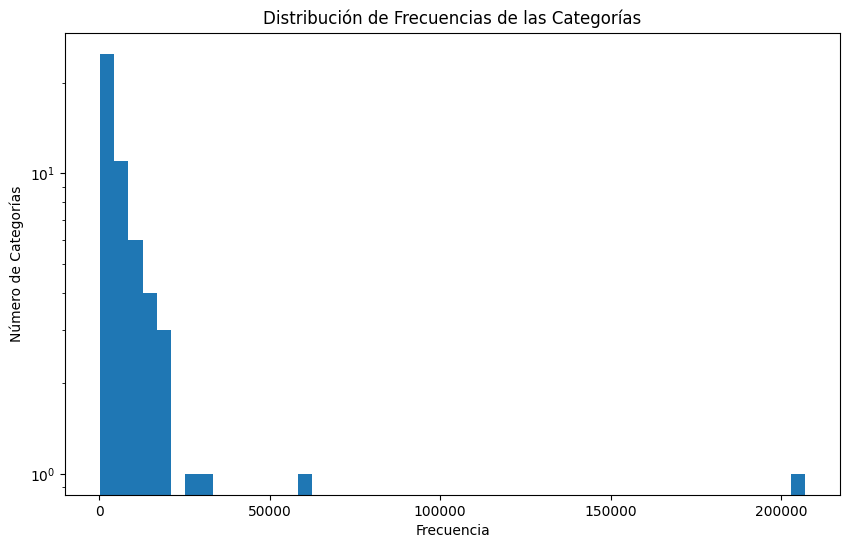

In [1966]:
# Calcular la distribución de frecuencias
plt.figure(figsize=(10, 6))
plt.hist(frequency_prov, bins=50, log=True)
plt.xlabel('Frecuencia')
plt.ylabel('Número de Categorías')
plt.title('Distribución de Frecuencias de las Categorías')
plt.show()

In [1967]:
# Definir un umbral basado en el percentil 80 (puedes ajustar este percentil)
threshold_prov= np.percentile(frequency_prov, 50)
print(f"Umbral basado en el percentil 90: {threshold_prov}")

Umbral basado en el percentil 90: 5159.0


Dado que no queremos perder demasiada granularidad y al mismo tiempo queremos agrupar las categorías con muy pocas observaciones, el percentil 50 (5159) parece un buen compromiso. Esto permitirá agrupar las categorías más pequeñas sin perder demasiada información detallada.

In [1968]:
dataset['cod_provincia_grouped'] = dataset['cod_provincia']
dataset.loc[dataset['cod_provincia'].isin(frequency_prov[frequency_prov < threshold_prov].index), 'cod_provincia_grouped'] = 'otras_provincias'
dataset['cod_provincia_grouped'].value_counts()

cod_provincia_grouped
Madrid              206951
otras_provincias     71668
Barcelona            60268
Valencia             32160
Sevilla              28197
A Coruña             19160
Murcia               18386
Málaga               16899
Zaragoza             16403
Alicante             14211
Cádiz                12844
Pontevedra           12819
Asturias             12471
Valladolid           10936
Las Palmas           10688
Badajoz               9079
Granada               8724
Toledo                8677
Bizkaia               8529
Salamanca             7520
Cantabria             7390
Córdoba               6895
Huelva                6217
Cáceres               6099
Islas Baleares        5670
Ciudad Real           5424
Albacete              5182
Castellón             5159
Name: count, dtype: int64

In [1969]:
dataset = pd.get_dummies(dataset, columns=['cod_provincia_grouped'])
dataset.drop(columns=['cod_provincia'], inplace=True)
dataset.head()

,cod_persona,mes,sexo,edad,fecha1,xti_nuevo_cliente,num_antiguedad,xti_rel,xti_rel_1mes,indresi,indext,xti_extra,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año,mes_indice,pais_binario,tip_rel_1mes_A,tip_rel_1mes_I,tip_rel_1mes_P,tip_rel_1mes_R,des_canal_grouped_KAB,des_canal_grouped_KAG,des_canal_grouped_KAS,des_canal_grouped_KAT,des_canal_grouped_KFA,des_canal_grouped_KFC,des_canal_grouped_KHD,des_canal_grouped_KHE,des_canal_grouped_KHK,des_canal_grouped_KHM,des_canal_grouped_KHN,des_canal_grouped_KHQ,des_canal_grouped_RED,des_canal_grouped_otros,cod_provincia_grouped_A Coruña,cod_provincia_grouped_Albacete,cod_provincia_grouped_Alicante,cod_provincia_grouped_Asturias,cod_provincia_grouped_Badajoz,cod_provincia_grouped_Barcelona,cod_provincia_grouped_Bizkaia,cod_provincia_grouped_Cantabria,cod_provincia_grouped_Castellón,cod_provincia_grouped_Ciudad Real,cod_provincia_grouped_Cáceres,cod_provincia_grouped_Cádiz,cod_provincia_grouped_Córdoba,cod_provincia_grouped_Granada,cod_provincia_grouped_Huelva,cod_provincia_grouped_Islas Baleares,cod_provincia_grouped_Las Palmas,cod_provincia_grouped_Madrid,cod_provincia_grouped_Murcia,cod_provincia_grouped_Málaga,cod_provincia_grouped_Pontevedra,cod_provincia_grouped_Salamanca,cod_provincia_grouped_Sevilla,cod_provincia_grouped_Toledo,cod_provincia_grouped_Valencia,cod_provincia_grouped_Valladolid,cod_provincia_grouped_Zaragoza,cod_provincia_grouped_otras_provincias
0,5514,2016-04-28,0,44,0,1.0,0,1,1.0,1,0,0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,5541,2016-04-28,0,60,0,1.0,0,1,1.0,1,0,0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,5631,2016-04-28,1,53,0,1.0,0,1,1.0,1,0,0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,5656,2016-04-28,0,47,0,1.0,0,1,1.0,1,0,0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,5738,2016-04-28,1,48,0,1.0,0,1,1.0,1,0,0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,15,1,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


### xti_actividad_cliente

Activity	index	(1,	active	customer;	0,	inactive	customer)


In [1970]:
dataset['xti_actividad_cliente'].isnull().sum()

0

In [1971]:
dataset['xti_actividad_cliente'].value_counts()

xti_actividad_cliente
0.0    343253
1.0    291373
Name: count, dtype: int64

In [1972]:
dataset['xti_actividad_cliente'] = dataset['xti_actividad_cliente'].astype(bool)

In [1973]:
dataset['xti_actividad_cliente'].value_counts()

xti_actividad_cliente
False    343253
True     291373
Name: count, dtype: int64

### mean_engagement


In [1974]:
dataset['mean_engagement'].isnull().sum()

5586

In [1975]:
# Calcular la mediana para mean_engagement
median_engagement = dataset['mean_engagement'].median()

In [1976]:
dataset.fillna({'mean_engagement': median_engagement}, inplace=True)

In [1977]:
dataset['mean_engagement'].value_counts()

mean_engagement
5.014352     36820
4.908936     34341
5.117500     33567
4.801096     30474
5.218520     21611
             ...  
26.141483        1
38.793123        1
31.202387        1
12.867631        1
28.218520        1
Name: count, Length: 203, dtype: int64

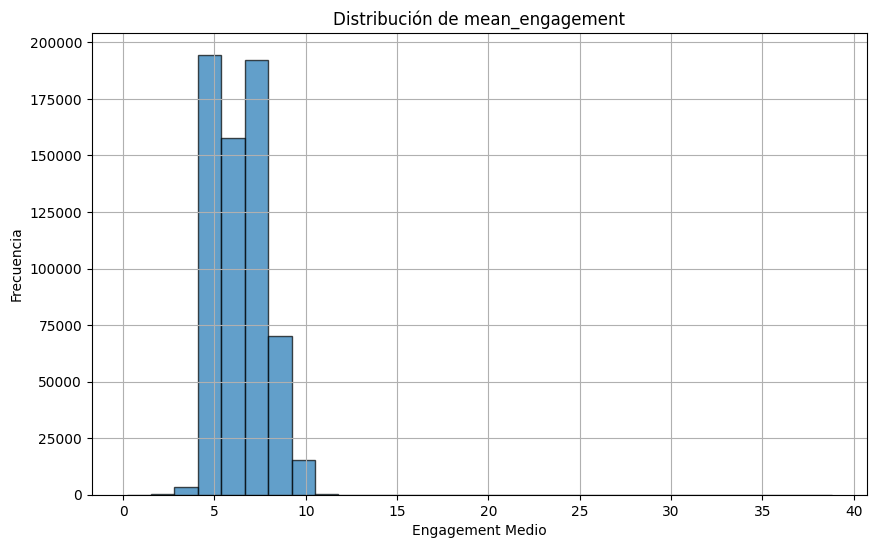

In [1978]:
# Plottear la distribución de mean_engagement
plt.figure(figsize=(10, 6))
plt.hist(dataset['mean_engagement'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribución de mean_engagement')
plt.xlabel('Engagement Medio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

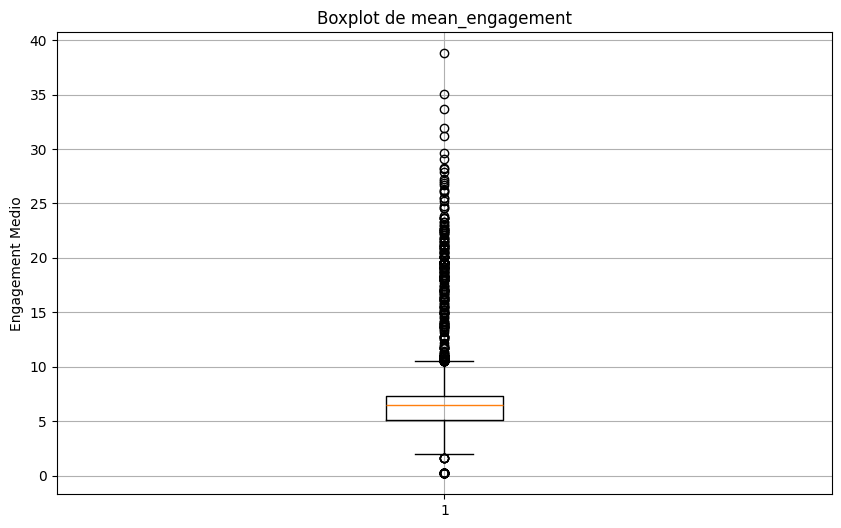

In [1979]:
# Check for outliers
plt.figure(figsize=(10, 6))
plt.boxplot(dataset['mean_engagement'])
plt.title('Boxplot de mean_engagement')
plt.ylabel('Engagement Medio')
plt.grid(True)
plt.show()

In [1980]:
# Calcular cuantos outliers hay
Q1 = dataset['mean_engagement'].quantile(0.25)
Q3 = dataset['mean_engagement'].quantile(0.75)
IQR = Q3 - Q1
outliers = dataset[(dataset['mean_engagement'] < (Q1 - 1.5 * IQR)) | (dataset['mean_engagement'] > (Q3 + 1.5 * IQR))]
print(f"Número de outliers: {outliers.shape[0]}")

Número de outliers: 341


In [1981]:
# aplicar winsorize
from scipy.stats.mstats import winsorize
dataset['mean_engagement'] = winsorize(dataset['mean_engagement'], limits=[0.05, 0.05])

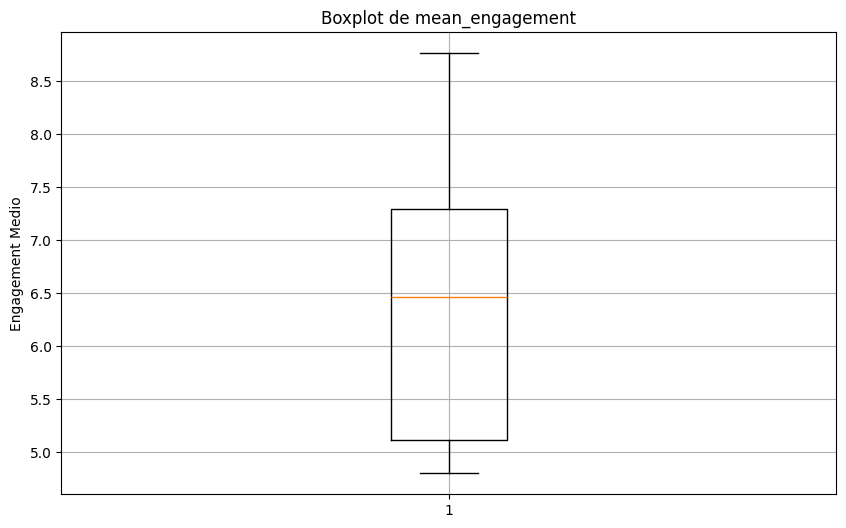

In [1982]:
plt.figure(figsize=(10, 6))
plt.boxplot(dataset['mean_engagement'])
plt.title('Boxplot de mean_engagement')
plt.ylabel('Engagement Medio')
plt.grid(True)
plt.show()

### id_segmento

Segmentation:	01	- VIP,	02	- Individuals	03	- college	graduated


In [1983]:
nulos_id_segmento = dataset['id_segmento'].isnull().sum()
print(f"Valores nulos en 'id_segmento': {nulos_id_segmento}")

Valores nulos en 'id_segmento': 7347


In [1984]:
ind_prod_columns = [col for col in dataset.columns if col.startswith('ind_prod')]
non_ind_prod_columns = [col for col in dataset.columns if not col.startswith('ind_prod')]

# Separar las columnas ind_prod del resto del dataset
dataset_non_ind_prod = dataset[non_ind_prod_columns]
dataset_non_ind_prod = dataset_non_ind_prod.drop(columns=['cod_persona', 'mes'])
dataset_ind_prod = dataset[ind_prod_columns]

In [1985]:
dataset_non_ind_prod.columns

Index(['sexo', 'edad', 'fecha1', 'xti_nuevo_cliente', 'num_antiguedad',
       'xti_rel', 'xti_rel_1mes', 'indresi', 'indext', 'xti_extra',
       'xti_actividad_cliente', 'imp_renta', 'id_segmento', 'mean_engagement',
       'mes_mes', 'mes_año', 'mes_indice', 'pais_binario', 'tip_rel_1mes_A',
       'tip_rel_1mes_I', 'tip_rel_1mes_P', 'tip_rel_1mes_R',
       'des_canal_grouped_KAB', 'des_canal_grouped_KAG',
       'des_canal_grouped_KAS', 'des_canal_grouped_KAT',
       'des_canal_grouped_KFA', 'des_canal_grouped_KFC',
       'des_canal_grouped_KHD', 'des_canal_grouped_KHE',
       'des_canal_grouped_KHK', 'des_canal_grouped_KHM',
       'des_canal_grouped_KHN', 'des_canal_grouped_KHQ',
       'des_canal_grouped_RED', 'des_canal_grouped_otros',
       'cod_provincia_grouped_A Coruña', 'cod_provincia_grouped_Albacete',
       'cod_provincia_grouped_Alicante', 'cod_provincia_grouped_Asturias',
       'cod_provincia_grouped_Badajoz', 'cod_provincia_grouped_Barcelona',
       'cod_provi

In [1986]:
complete_data = dataset_non_ind_prod[dataset_non_ind_prod['id_segmento'].notnull()]
missing_data = dataset_non_ind_prod[dataset_non_ind_prod['id_segmento'].isnull()]

In [1987]:
X = complete_data.drop('id_segmento', axis=1)
y = complete_data['id_segmento']

In [1988]:
model = RandomForestClassifier()
model.fit(X, y)

RandomForestClassifier()

In [1989]:
missing_X = missing_data.drop('id_segmento', axis=1)
predicted_values = model.predict(missing_X)

In [1990]:
# Evaluar la precisión del modelo
accuracy = model.score(X, y)
print(f'Precisión del modelo: {accuracy}')

Precisión del modelo: 0.9998246394347651


In [1991]:
dataset.loc[dataset['id_segmento'].isnull(), 'id_segmento'] = predicted_values

In [1992]:
dataset['id_segmento'].isnull().sum()

0

In [1993]:
dataset['id_segmento'].value_counts()

id_segmento
02 - PARTICULARES     373269
03 - UNIVERSITARIO    234769
01 - TOP               26588
Name: count, dtype: int64

In [1994]:
dataset = pd.get_dummies(dataset, columns=['id_segmento'])

### imp_renta

Gross	income	of	the	household


In [1995]:
dataset['imp_renta'].isnull().sum()

124108

In [1996]:
# Identificar las columnas ind_prod
ind_prod_columns = [col for col in dataset.columns if col.startswith('ind_prod')]
non_ind_prod_columns = [col for col in dataset.columns if not col.startswith('ind_prod')]

# Separar las columnas ind_prod del resto del dataset
dataset_non_ind_prod = dataset[non_ind_prod_columns]
dataset_non_ind_prod = dataset_non_ind_prod.drop(columns=['cod_persona', 'mes'])
dataset_ind_prod = dataset[ind_prod_columns]

In [1997]:
# Separar datos completos y datos con valores faltantes en 'imp_renta'
complete_data = dataset_non_ind_prod[dataset_non_ind_prod['imp_renta'].notnull()]
missing_data = dataset_non_ind_prod[dataset_non_ind_prod['imp_renta'].isnull()]

# Dividir los datos completos en características (X) y target (y)
X = complete_data.drop('imp_renta', axis=1)
y = complete_data['imp_renta']

In [1998]:
# Crear y entrenar el modelo de regresión
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [1999]:
# Predecir los valores faltantes en 'imp_renta'
missing_X = missing_data.drop('imp_renta', axis=1)
predicted_values = model.predict(missing_X)

In [2000]:
# Evaluar la precisión del modelo usando RMSE
y_pred = model.predict(X)
rmse = mean_squared_error(y, y_pred, squared=False)
print(f'RMSE del modelo: {rmse}')

RMSE del modelo: 111129.71095713277


C:\Users\crix-\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [2001]:
r2 = r2_score(y, y_pred)
mape = np.mean(np.abs((y - y_pred) / y)) * 100
print(f'R² del modelo: {r2}')
print(f'MAPE del modelo: {mape}') ## Tenemos un error del 16%

R² del modelo: 0.8892645704894439
MAPE del modelo: 16.423423351986834


In [2002]:
dataset.loc[dataset['imp_renta'].isnull(), 'imp_renta'] = predicted_values


## Calculo de nulos en todas las columnas:

Dropeamos la columna mes


In [2003]:
dataset.drop(columns=['mes'], inplace=True)

In [2004]:
print(dataset.isnull().sum())


cod_persona                               0
sexo                                      0
edad                                      0
fecha1                                    0
xti_nuevo_cliente                         0
                                         ..
cod_provincia_grouped_Zaragoza            0
cod_provincia_grouped_otras_provincias    0
id_segmento_01 - TOP                      0
id_segmento_02 - PARTICULARES             0
id_segmento_03 - UNIVERSITARIO            0
Length: 92, dtype: int64


In [2005]:
dataset.describe()

,cod_persona,sexo,edad,fecha1,xti_nuevo_cliente,num_antiguedad,xti_rel,xti_rel_1mes,indresi,indext,xti_extra,imp_renta,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año,mes_indice,pais_binario
count,6.346260e+05,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.0,634626.000000,634626.0,6.346260e+05,634626.000000,634626.000000,634626.0,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634623.000000,634623.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000,634626.000000
mean,7.217845e+05,0.546549,40.119201,79.737297,0.059846,79.451412,0.999943,1.000591,0.995446,0.047913,0.002392,1.332652e+05,6.410082,0.000101,0.0,0.660978,0.000495,0.081747,0.009993,0.009823,0.131920,0.043508,0.002026,0.001899,0.043441,0.083140,0.018699,0.005276,0.009264,0.002718,0.053562,0.045507,0.026505,0.003757,0.055564,0.060297,0.128835,0.065880,5.716684,2015.292465,8.226266,0.995446
std,4.290892e+05,0.497829,17.208281,66.694892,0.237202,66.325191,0.007531,0.036657,0.067329,0.213583,0.048849,3.061078e+05,1.234895,0.010042,0.0,0.473378,0.022238,0.273980,0.099466,0.098624,0.338404,0.203997,0.044970,0.043533,0.203849,0.276094,0.135461,0.072441,0.095801,0.052065,0.225152,0.208414,0.160633,0.061175,0.229077,0.238037,0.335017,0.248072,3.602581,0.454895,4.499700,0.067329
min,5.514000e+03,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,4.559550e+03,4.801096,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2015.000000,0.000000,0.000000
25%,3.584450e+05,0.000000,24.000000,22.000000,0.000000,23.000000,1.000000,1.000000,1.0,0.000000,0.0,7.042671e+04,5.117500,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2015.000000,5.000000,1.000000
50%,6.230810e+05,1.000000,39.000000,51.000000,0.000000,50.000000,1.000000,1.000000,1.0,0.000000,0.0,1.002821e+05,6.463518,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2015.000000,9.000000,1.000000
75%,1.102693e+06,1.000000,50.000000,137.000000,0.000000,135.000000,1.000000,1.000000,1.0,0.000000,0.0,1.514304e+05,7.289588,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,2016.000000,12.000000,1.000000
max,1.537800e+06,1.000000,117.000000,255.000000,1.000000,255.000000,1.000000,4.000000,1.0,1.000000,1.0,2.889440e+07,8.762524,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,2016.000000,15.000000,1.000000


In [2006]:
dataset.loc[dataset['cod_persona'] == 319866]

,cod_persona,sexo,edad,fecha1,xti_nuevo_cliente,num_antiguedad,xti_rel,xti_rel_1mes,indresi,indext,xti_extra,xti_actividad_cliente,imp_renta,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año,mes_indice,pais_binario,tip_rel_1mes_A,tip_rel_1mes_I,tip_rel_1mes_P,tip_rel_1mes_R,des_canal_grouped_KAB,des_canal_grouped_KAG,des_canal_grouped_KAS,des_canal_grouped_KAT,des_canal_grouped_KFA,des_canal_grouped_KFC,des_canal_grouped_KHD,des_canal_grouped_KHE,des_canal_grouped_KHK,des_canal_grouped_KHM,des_canal_grouped_KHN,des_canal_grouped_KHQ,des_canal_grouped_RED,des_canal_grouped_otros,cod_provincia_grouped_A Coruña,cod_provincia_grouped_Albacete,cod_provincia_grouped_Alicante,cod_provincia_grouped_Asturias,cod_provincia_grouped_Badajoz,cod_provincia_grouped_Barcelona,cod_provincia_grouped_Bizkaia,cod_provincia_grouped_Cantabria,cod_provincia_grouped_Castellón,cod_provincia_grouped_Ciudad Real,cod_provincia_grouped_Cáceres,cod_provincia_grouped_Cádiz,cod_provincia_grouped_Córdoba,cod_provincia_grouped_Granada,cod_provincia_grouped_Huelva,cod_provincia_grouped_Islas Baleares,cod_provincia_grouped_Las Palmas,cod_provincia_grouped_Madrid,cod_provincia_grouped_Murcia,cod_provincia_grouped_Málaga,cod_provincia_grouped_Pontevedra,cod_provincia_grouped_Salamanca,cod_provincia_grouped_Sevilla,cod_provincia_grouped_Toledo,cod_provincia_grouped_Valencia,cod_provincia_grouped_Valladolid,cod_provincia_grouped_Zaragoza,cod_provincia_grouped_otras_provincias,id_segmento_01 - TOP,id_segmento_02 - PARTICULARES,id_segmento_03 - UNIVERSITARIO
134249,319866,1,23,13,0.0,19,1,1.0,1,0,0,False,110344.65,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,0,1,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
134250,319866,1,23,14,0.0,19,1,1.0,1,0,0,False,110344.65,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,2,2015,1,1,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
134251,319866,1,23,15,0.0,19,1,1.0,1,0,0,False,110344.65,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,3,2015,2,1,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
134252,319866,1,23,16,0.0,19,1,1.0,1,0,0,False,110344.65,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2015,3,1,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
134253,319866,1,23,17,0.0,19,1,1.0,1,0,0,False,110344.65,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,5,2015,4,1,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
134254,319866,1,23,18,0.0,19,1,1.0,1,0,0,False,110344.65,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [2007]:
output_file_path = 'dataset_limpio.csv'
dataset.to_csv(output_file_path, index=False)

PermissionError: [Errno 13] Permission denied: 'dataset_limpio.csv'